# Retail Sales Forecasting

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

## Data Preparation

The dataset is available on kaggle

In [37]:
# Load the dataset with a different encoding
file_path = 'data/store-sales-forecasting.csv'
data = pd.read_csv(file_path, encoding='latin1')

data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
3,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
4,11,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


### Feature Optimization

Features to Keep:
1. Order Date: To determine the sales month.
2. Sales: To calculate the total monthly sales.
Additionally, consider keeping features that might provide insights into sales trends, such as:
3. Segment: To analyze sales trends across different customer segments.
4. Ship Mode: To see if different shipping modes impact sales.
5. Region: To understand regional sales trends.

Features to Remove:
1. Row ID: Only serves as a unique identifier and does not contribute to forecasting.
2. Order ID: Similar to Row ID, it doesn't contribute directly to forecasting.
3. Ship Date: Not directly relevant to sales forecasting.
4. Customer ID: Individual customer tracking is less relevant for aggregate monthly sales.
5. Customer Name: Personal details not necessary for sales forecasting.
6. Country: If all data points are from the same country, this is redundant.
7. City: Can be too granular for monthly forecasting; Region is more relevant.
8. State: Similar to City, might be too granular if Region is included.
9. Postal Code: Too granular.
10. Product ID: Detailed product information may not be necessary for overall sales trends.
11. Product Name: Not needed if Product ID is excluded.
12. Quantity: Total sales amount is more relevant.
13. Discount: Could be removed unless you want to analyze its effect on sales.
14. Profit: Not directly related to the total sales amount; can be analyzed separately.


In [38]:
# Remove unnecessary columns
columns_to_remove = [
    'Row ID', 'Order ID', 'Ship Date', 'Customer ID', 'Customer Name',
    'Country', 'City', 'State', 'Postal Code', 'Product ID', 'Product Name',
    'Quantity', 'Discount'
]
data = data.drop(columns=columns_to_remove)

In [39]:
# Convert 'Order Date' to datetime
data['Order Date'] = pd.to_datetime(data['Order Date'])

# Ensure 'Sales' is numeric
data['Sales'] = pd.to_numeric(data['Sales'], errors='coerce')

# Drop rows with invalid 'Sales' values
data = data.dropna(subset=['Sales'])

# Extract month-year period
data['Month'] = data['Order Date'].dt.to_period('M')

## Exploratory Data Analysis

In [40]:
# Extract year and month
data['Year'] = data['Order Date'].dt.year
data['Month'] = data['Order Date'].dt.month

In [41]:
# Summary Statistics
print(data["Sales"].describe())

count    2121.000000
mean      349.834887
std       503.179145
min         1.892000
25%        47.040000
50%       182.220000
75%       435.168000
max      4416.174000
Name: Sales, dtype: float64


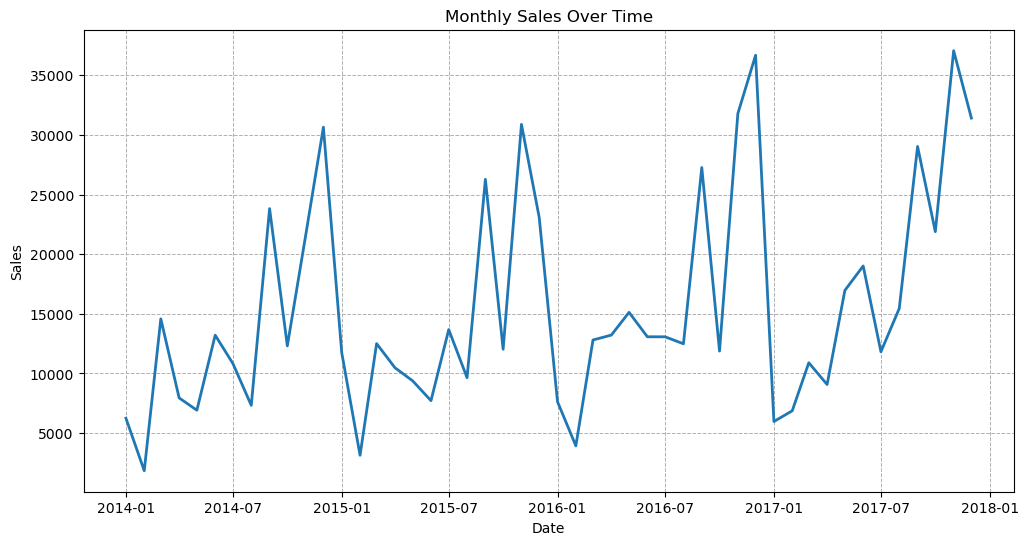

In [42]:
# Sales Trends Over Time
monthly_sales = data.groupby(data['Order Date'].dt.to_period('M')).agg({'Sales': 'sum'}).reset_index()
monthly_sales['Order Date'] = monthly_sales['Order Date'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
sns.lineplot(x='Order Date', y='Sales', data=monthly_sales, linewidth=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

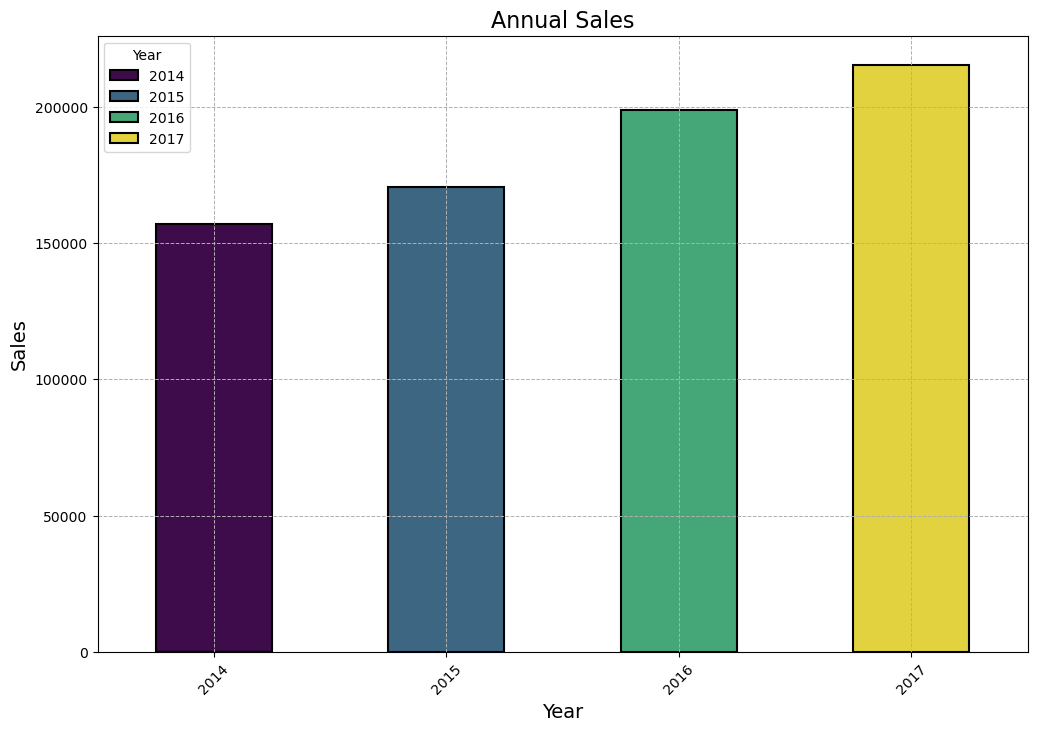

In [43]:
# Yearly Sales
yearly_sales = data.groupby('Year').agg({'Sales': 'sum'}).reset_index().sort_values(by='Sales', ascending=False)

plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='Year', y='Sales', data=yearly_sales, palette="viridis", hue="Year", edgecolor='black', linewidth=1.5)

# Customize the bars to make them leaner and centered
for bar in barplot.patches:
    x = bar.get_x()
    width = bar.get_width()
    bar.set_width(0.5)  # Set new width
    bar.set_x(x + (width - bar.get_width()) / 2)  # Adjust position to keep centered

# Add a grid
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

plt.title('Annual Sales', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.xticks(rotation=45)
plt.show()


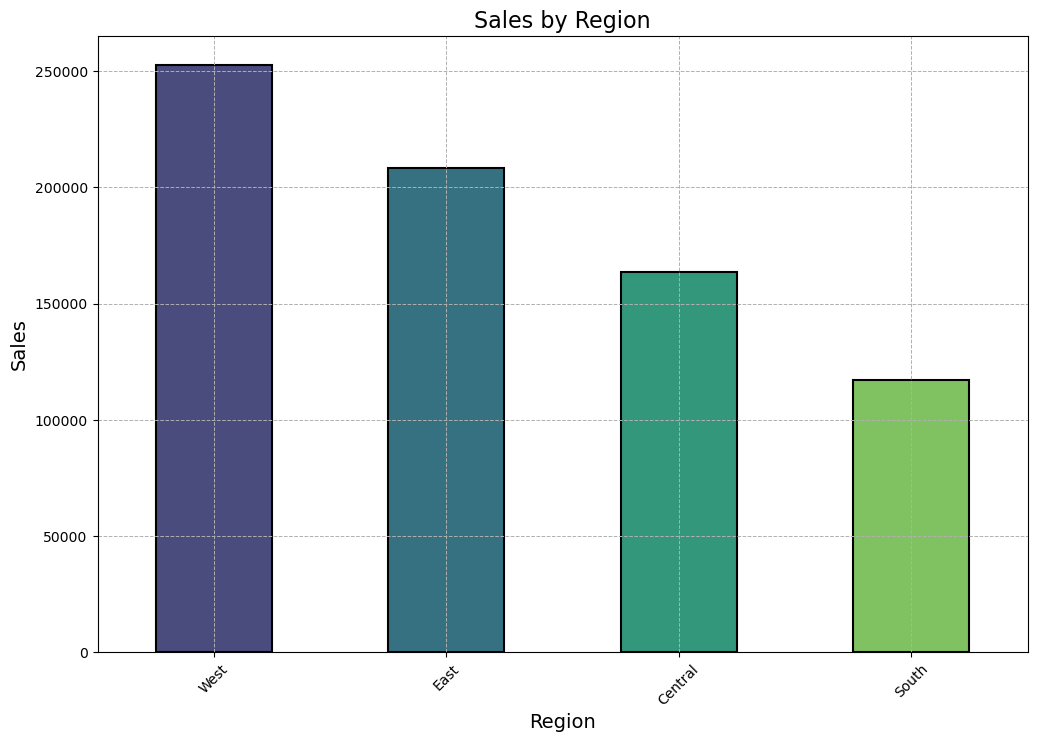

In [44]:
# Sales by Region
region_sales = data.groupby('Region').agg({'Sales': 'sum'}).reset_index().sort_values(by='Sales', ascending=False)

plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='Region', y='Sales', data=region_sales, palette="viridis", hue="Region", edgecolor='black', linewidth=1.5)

# Customize the bars to make them leaner and centered
for bar in barplot.patches:
    x = bar.get_x()
    width = bar.get_width()
    bar.set_width(0.5)  # Set new width
    bar.set_x(x + (width - bar.get_width()) / 2)  # Adjust position to keep centered

# Add a grid
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

plt.title('Sales by Region', fontsize=16)
plt.xlabel('Region', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.xticks(rotation=45)
plt.show()


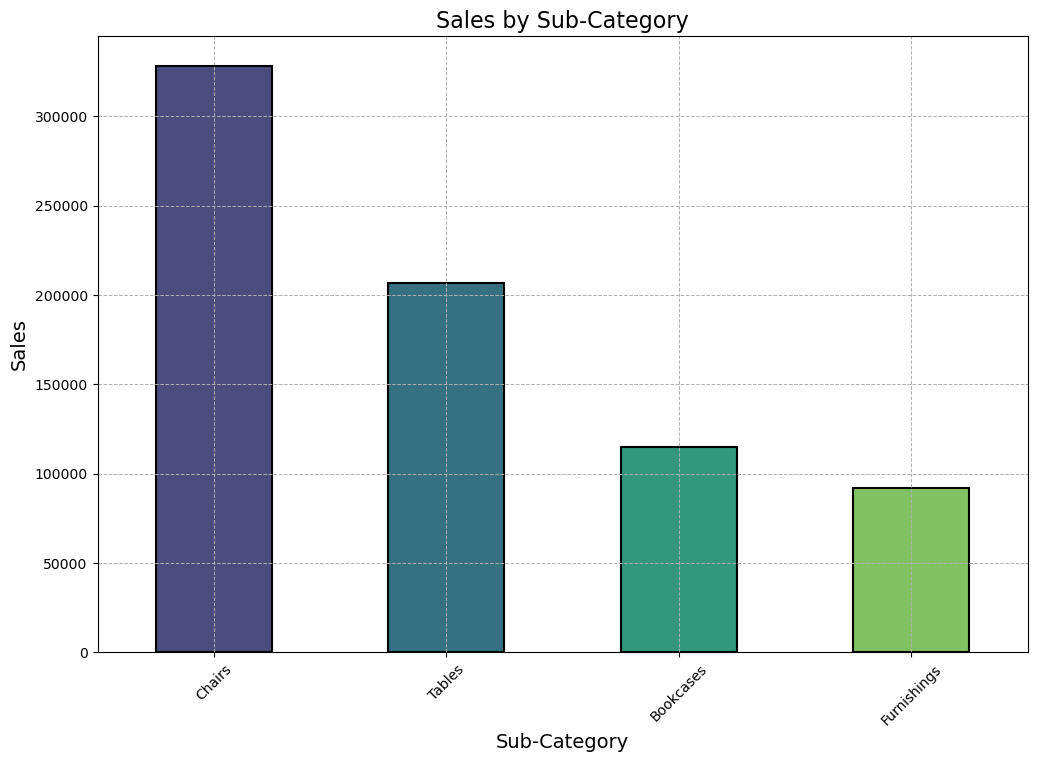

In [45]:
# Sales by Sub-Category
sub_category_sales = data.groupby('Sub-Category').agg({'Sales': 'sum'}).reset_index().sort_values(by='Sales', ascending=False)

plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='Sub-Category', y='Sales', data=sub_category_sales, palette="viridis", hue="Sub-Category", edgecolor='black', linewidth=1.5)

# Customize the bars to make them leaner and centered
for bar in barplot.patches:
    x = bar.get_x()
    width = bar.get_width()
    bar.set_width(0.5)  # Set new width
    bar.set_x(x + (width - bar.get_width()) / 2)  # Adjust position to keep centered

# Add a grid
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

plt.title('Sales by Sub-Category', fontsize=16)
plt.xlabel('Sub-Category', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.xticks(rotation=45)
plt.show()

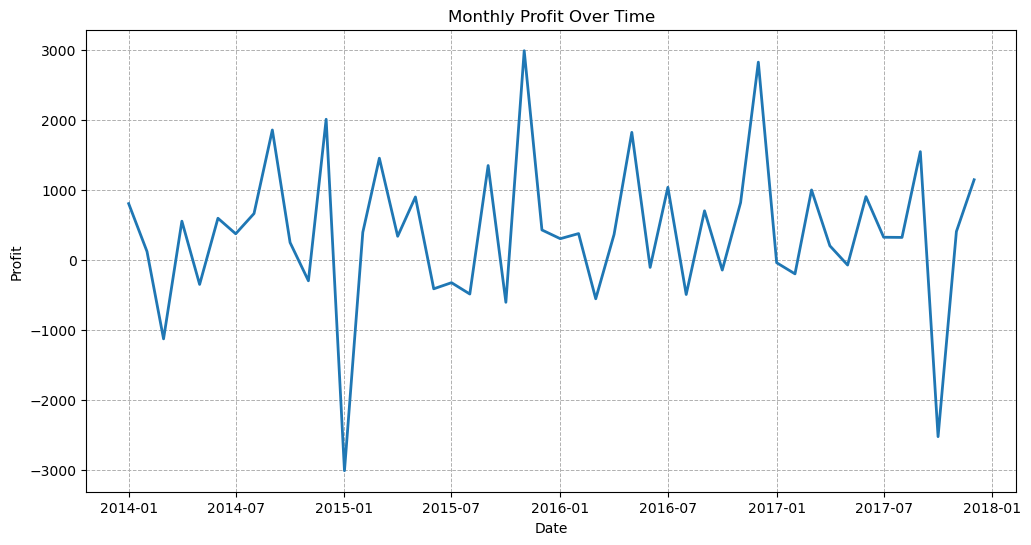

In [46]:
# Profit Trends Over Time
monthly_profit = data.groupby(data['Order Date'].dt.to_period('M')).agg({'Profit': 'sum'}).reset_index()
monthly_profit['Order Date'] = monthly_profit['Order Date'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
sns.lineplot(x='Order Date', y='Profit', data=monthly_profit, linewidth=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.title('Monthly Profit Over Time')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.show()


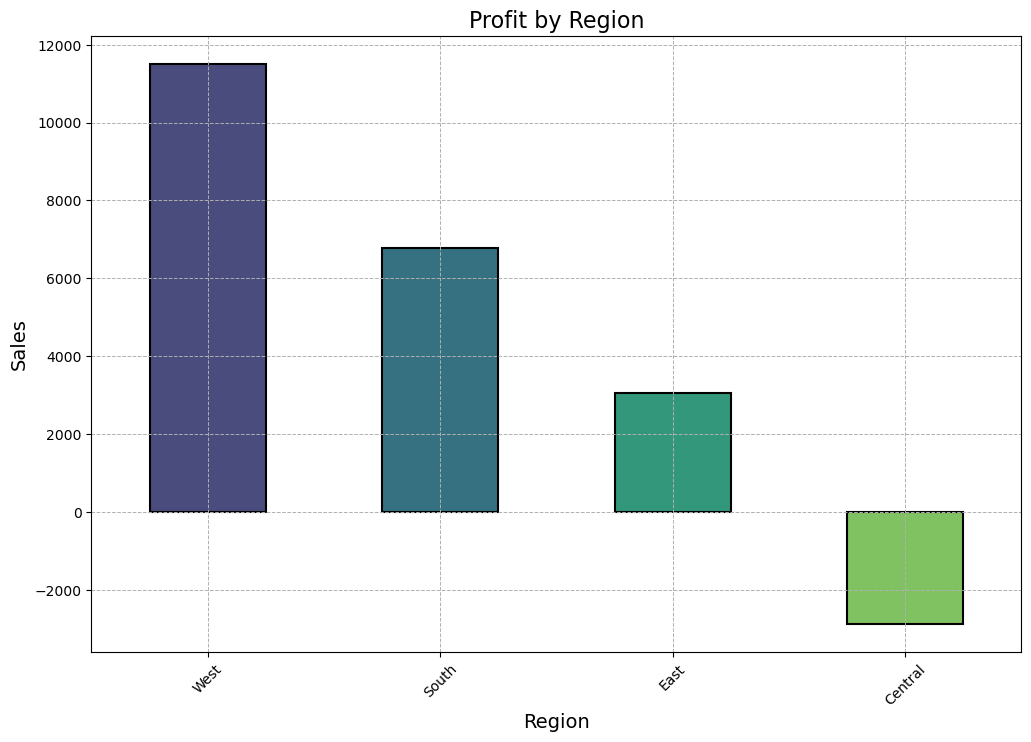

In [47]:
# Profit by Region
region_profit = data.groupby('Region').agg({'Profit': 'sum'}).reset_index().sort_values(by='Profit', ascending=False)

plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='Region', y='Profit', data=region_profit, palette="viridis", hue="Region", edgecolor='black', linewidth=1.5)

# Customize the bars to make them leaner and centered
for bar in barplot.patches:
    x = bar.get_x()
    width = bar.get_width()
    bar.set_width(0.5)  # Set new width
    bar.set_x(x + (width - bar.get_width()) / 2)  # Adjust position to keep centered

# Add a grid
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

plt.title('Profit by Region', fontsize=16)
plt.xlabel('Region', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.xticks(rotation=45)
plt.show()

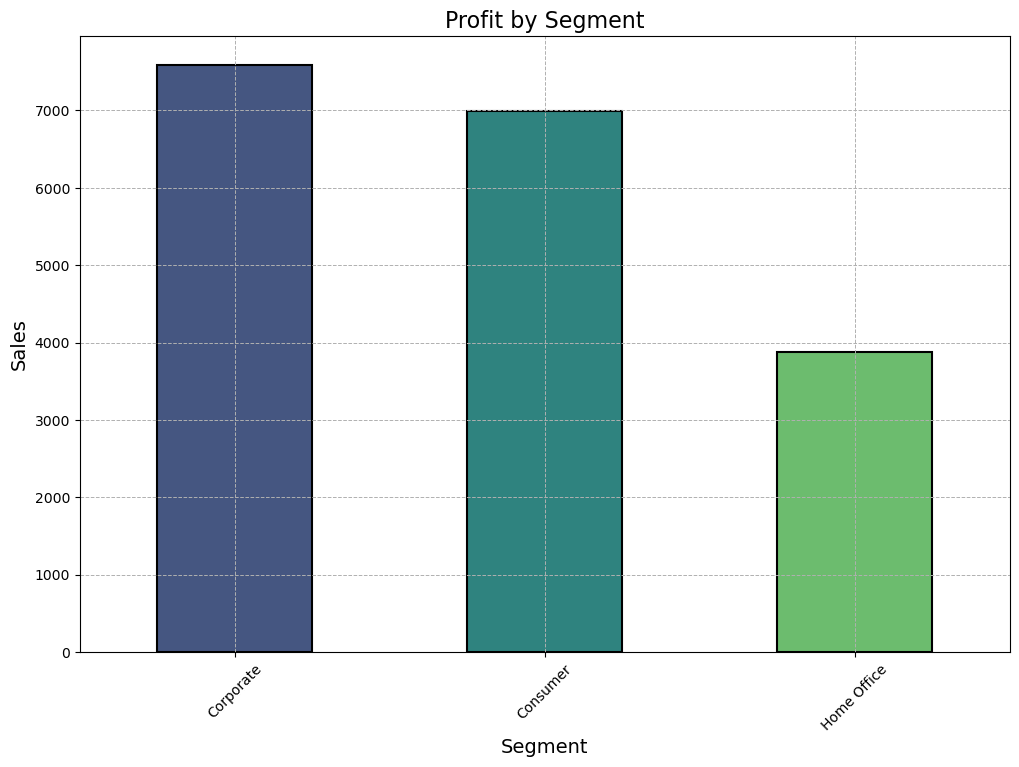

In [48]:
# Profit by Segment
segment_profit = data.groupby('Segment').agg({'Profit': 'sum'}).reset_index().sort_values(by='Profit', ascending=False)

plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='Segment', y='Profit', data=segment_profit, palette="viridis", hue="Segment", edgecolor='black', linewidth=1.5)

# Customize the bars to make them leaner and centered
for bar in barplot.patches:
    x = bar.get_x()
    width = bar.get_width()
    bar.set_width(0.5)  # Set new width
    bar.set_x(x + (width - bar.get_width()) / 2)  # Adjust position to keep centered

# Add a grid
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

plt.title('Profit by Segment', fontsize=16)
plt.xlabel('Segment', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.xticks(rotation=45)
plt.show()

## Model Building (Default Hyperparameters)

In [49]:
# Convert 'Order Date' to datetime and extract month-year period
data['Order Date'] = pd.to_datetime(data['Order Date'])
data['Month'] = data['Order Date'].dt.to_period('M')

In [50]:
# Aggregate monthly sales
monthly_sales = data.groupby('Month').agg({
    'Sales': 'sum',
    'Segment': 'first',
    'Ship Mode': 'first',
    'Region': 'first'
}).reset_index()

In [51]:
# Convert 'Month' to string for plotting
monthly_sales['Month'] = monthly_sales['Month'].astype(str)

# Extract additional time-based features
monthly_sales['Year'] = pd.to_datetime(monthly_sales['Month']).dt.year
monthly_sales['Month_Num'] = pd.to_datetime(monthly_sales['Month']).dt.month

# Encode categorical features
monthly_sales_encoded = pd.get_dummies(monthly_sales, columns=['Segment', 'Ship Mode', 'Region'])

In [52]:
# Define features and target variable
X = monthly_sales_encoded.drop(columns=['Sales', 'Month'])
y = monthly_sales_encoded['Sales']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
# Train and evaluate with default parameters
rf_model_default = RandomForestRegressor(random_state=42)
rf_model_default.fit(X_train, y_train)

y_pred_train_default = rf_model_default.predict(X_train)
y_pred_test_default = rf_model_default.predict(X_test)

In [54]:
mae_train_default = mean_absolute_error(y_train, y_pred_train_default)
mse_train_default = mean_squared_error(y_train, y_pred_train_default)
rmse_train_default = root_mean_squared_error(y_train, y_pred_train_default)
mae_test_default = mean_absolute_error(y_test, y_pred_test_default)
mse_test_default = mean_squared_error(y_test, y_pred_test_default)
rmse_test_default = root_mean_squared_error(y_test, y_pred_test_default)


print(f"Training MAE: {mae_train_default}, Training MSE: {mse_train_default}")
print(f"Testing MAE: {mae_test_default}, Testing MSE: {mse_test_default}")

Training MAE: 1544.7133419210488, Training MSE: 3579592.4184629954
Testing MAE: 2712.4808404999976, Testing MSE: 11110331.275853956


## Model Building (GridSearchCV)

In [55]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [56]:
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')

In [57]:
# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters from GridSearchCV: ", best_params)

Best Parameters from GridSearchCV:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


In [58]:
# Get the best estimator
best_rf_model = grid_search.best_estimator_

# Train and evaluate with GridSearchCV parameters
y_pred_train_grid = best_rf_model.predict(X_train)
y_pred_test_grid = best_rf_model.predict(X_test)

In [59]:
mae_train_grid = mean_absolute_error(y_train, y_pred_train_grid)
mse_train_grid = mean_squared_error(y_train, y_pred_train_grid)
rmse_train_grid = root_mean_squared_error(y_train, y_pred_train_grid)
mae_test_grid = mean_absolute_error(y_test, y_pred_test_grid)
mse_test_grid = mean_squared_error(y_test, y_pred_test_grid)
rmse_test_grid = root_mean_squared_error(y_test, y_pred_test_grid)

print("GridSearchCV Model")
print(f"Training MAE: {mae_train_grid}, Testing MAE: {mae_test_grid}")
print(f"Training MAE: {mse_train_grid}, Testing MSE: {mse_test_grid}")
print(f"Training RMSE: {rmse_train_grid}, Testing MSE: {rmse_test_grid}")

GridSearchCV Model
Training MAE: 2223.1073195427466, Testing MAE: 2587.6454084738516
Training MAE: 7702456.57663222, Testing MSE: 9576669.612127297
Training RMSE: 2775.329994186677, Testing MSE: 3094.6194616022335


In [60]:
# Compare actual vs. predicted sales for both models
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted_Default': y_pred_test_default,
    'Predicted_GridSearchCV': y_pred_test_grid
})
print(comparison_df.head())

        Actual  Predicted_Default  Predicted_GridSearchCV
27  13212.0900       10786.386264            10791.338846
40  16957.5582       11564.202049            11386.444433
26  12801.0920       11043.150451            10731.522383
43  15441.8740       15134.563319            14423.824529
24   7622.7430        4993.363151             5779.291705


## Model Evaluation

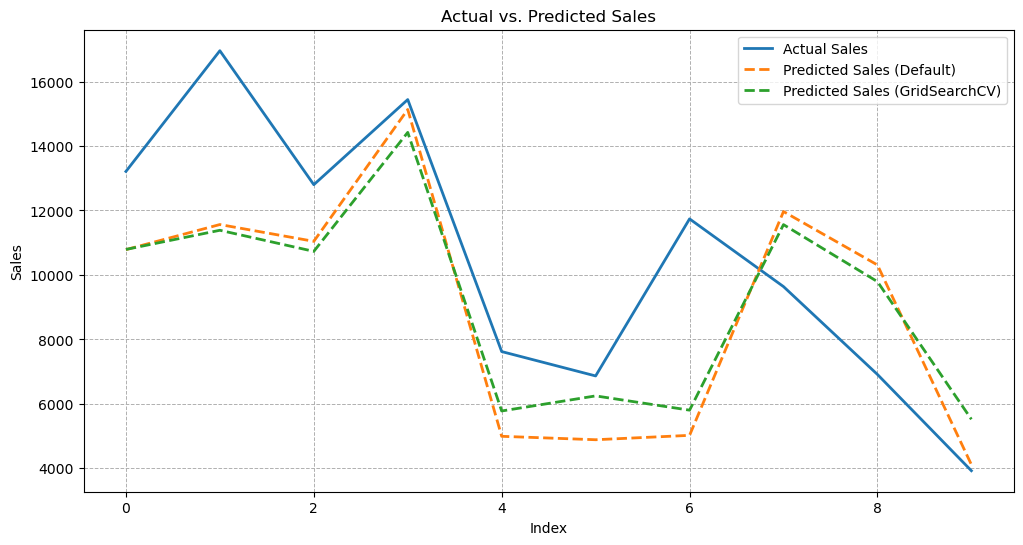

In [61]:
# Plot actual vs. predicted sales for both models
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Actual'].values, label='Actual Sales', linewidth=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.plot(comparison_df['Predicted_Default'].values, label='Predicted Sales (Default)', linestyle='--', linewidth=2)
plt.plot(comparison_df['Predicted_GridSearchCV'].values, label='Predicted Sales (GridSearchCV)', linestyle='--', linewidth=2)
plt.legend()
plt.title('Actual vs. Predicted Sales')
plt.xlabel('Index')
plt.ylabel('Sales')
plt.show()

## Future Sales Prediction

In [62]:
# Get the exact column names for the encoded categorical features
segment_columns = [col for col in X.columns if 'Segment' in col]
ship_mode_columns = [col for col in X.columns if 'Ship Mode' in col]
region_columns = [col for col in X.columns if 'Region' in col]

In [63]:
# Use the most common Segment, Ship Mode, and Region values from training data
most_common_segment = X[segment_columns].mode().iloc[0]
most_common_ship_mode = X[ship_mode_columns].mode().iloc[0]
most_common_region = X[region_columns].mode().iloc[0]

In [64]:
# Extend the Date Range
future_dates = pd.date_range(start='2020-01-01', periods=12, freq='ME')

In [65]:
# Prepare Future Features
future_df = pd.DataFrame({'Month': future_dates.to_period('M')})
future_df['Month'] = future_df['Month'].astype(str)
future_df['Year'] = future_dates.year
future_df['Month_Num'] = future_dates.month

In [66]:
# Initialize future DataFrame with most common values
for col in segment_columns:
    future_df[col] = most_common_segment[col]

for col in ship_mode_columns:
    future_df[col] = most_common_ship_mode[col]

for col in region_columns:
    future_df[col] = most_common_region[col]

In [67]:
# Align columns with the training data
future_df_encoded = future_df.reindex(columns=X.columns, fill_value=0)

# 3. Make Predictions
future_sales_predictions = best_rf_model.predict(future_df_encoded)

In [68]:
# Create a DataFrame to hold future dates and their predicted sales
future_sales_df = pd.DataFrame({
    'Month': future_dates,
    'Predicted_Sales': future_sales_predictions
})

In [69]:
# Display future sales predictions
print(future_sales_df)

        Month  Predicted_Sales
0  2020-01-31      5658.513740
1  2020-02-29      5375.360395
2  2020-03-31     10776.816856
3  2020-04-30     11051.480636
4  2020-05-31     11495.317404
5  2020-06-30     12180.437584
6  2020-07-31     12130.985563
7  2020-08-31     12055.265069
8  2020-09-30     24147.879143
9  2020-10-31     17626.407767
10 2020-11-30     28220.918823
11 2020-12-31     28612.781739


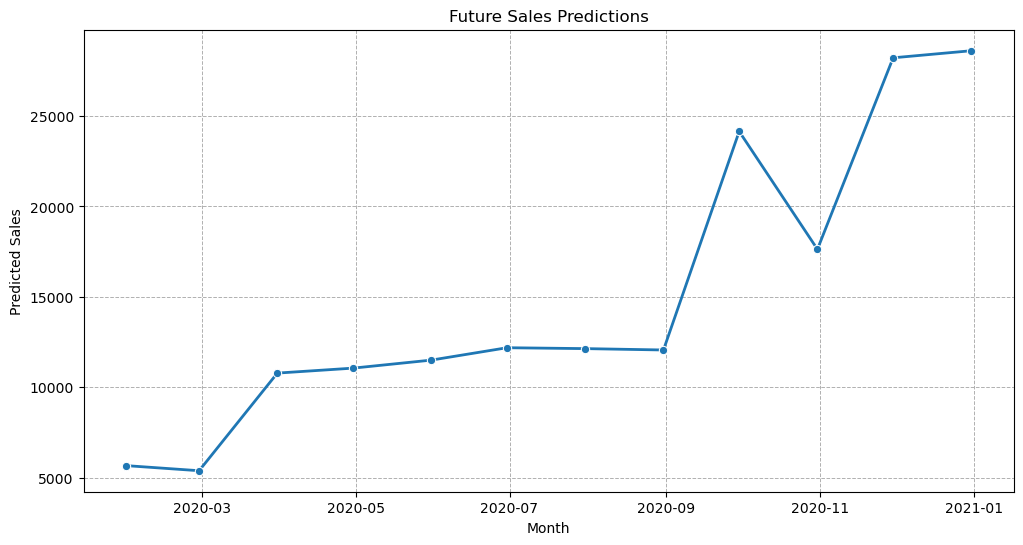

In [70]:
# Plot future sales predictions
plt.figure(figsize=(12, 6))
sns.lineplot(x='Month', y='Predicted_Sales', data=future_sales_df, marker='o', linewidth=2)
plt.title('Future Sales Predictions')
plt.xlabel('Month')
plt.ylabel('Predicted Sales')
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.show()